In [12]:
## 2. Setup

import math
import random
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.strtree import STRtree
from tqdm.notebook import tqdm

# Set random seed
SEED = 2025
random.seed(SEED)
np.random.seed(SEED)

# High precision for coordinates
getcontext().prec = 50

print("Libraries imported and seed set.")

Libraries imported and seed set.


In [13]:
# Configuration for Advanced Features
CONFIG = {
    # Hybrid Search Approach
    'hybrid_search': {
        'enabled': True,
        'switch_n': 25,  # Use forward building for N <= 25
    },
    
    # Dynamic Beam Width
    'dynamic_beam_width': {
        'enabled': True,
        'base_width': 12,
        'critical_n_multiplier': 2.0, # Wider for critical sizes
    },
    
    # Beam Search Diversity
    'beam_diversity': {
        'enabled': True,
        'max_children_per_parent': 3, # Prevent one parent from dominating the next generation
    },
    
    # Multi-Start Optimization
    'multi_start': {
        'enabled': True,
        'n_starts': 3,
    },
    
    # Optimization Function Enhancements
    'optimization': {
        'adaptive_temperature': True,
        'smart_move_selection': True, # Bias moves toward boundary
        'batch_moves': False, # Try moving multiple trees (complex)
        'boundary_bias_strength': 0.7, # 70% chance to pick boundary tree
        'reheating': True, # Restart SA if stuck
        'compaction_pass': True, # Pure translation pass to close gaps
    },
    
    # Post-Processing & Polishing
    'post_processing': {
        'polishing': True, # Run a low-temp refinement phase at the end
        'polishing_iterations': 2000,
    },
    
    # Geometric & Heuristic Improvements
    'heuristics': {
        'corner_filling': True,
        'symmetry_breaking': True,
        'boundary_alignment': True,
    },
    
    # Validation
    'validation': {
        'strict_boundary': True,
        'collision_check': True,
    },
    
    # Debugging
    'debug': {
        'verbose_logging': True,
        'plot_convergence': True,
    }
}

print("Configuration loaded:", CONFIG)

Configuration loaded: {'hybrid_search': {'enabled': True, 'switch_n': 25}, 'dynamic_beam_width': {'enabled': True, 'base_width': 12, 'critical_n_multiplier': 2.0}, 'beam_diversity': {'enabled': True, 'max_children_per_parent': 3}, 'multi_start': {'enabled': True, 'n_starts': 3}, 'optimization': {'adaptive_temperature': True, 'smart_move_selection': True, 'batch_moves': False, 'boundary_bias_strength': 0.7, 'reheating': True, 'compaction_pass': True}, 'post_processing': {'polishing': True, 'polishing_iterations': 2000}, 'heuristics': {'corner_filling': True, 'symmetry_breaking': True, 'boundary_alignment': True}, 'validation': {'strict_boundary': True, 'collision_check': True}, 'debug': {'verbose_logging': True, 'plot_convergence': True}}


In [14]:
## 3. Load Data

# Load the sample submission to understand the required output format
try:
    sample_sub = pd.read_csv('test.csv')
    print("Sample Submission Shape:", sample_sub.shape)
    print(sample_sub.head())
except FileNotFoundError:
    print("Sample submission not found, proceeding without it.")

Sample Submission Shape: (20100, 4)
      id                      x                     y                  deg
0  001_0  s-0.10321808021039558  s0.34047120947325865                s45.0
1  002_1    s0.7266529621437997   s0.6407319876192062  s-156.3702262413503
2  002_0    s0.4184690921438004  s0.11780120761920625  s23.630851286582345
3  003_1              s1.017555             s1.154083          s155.134174
4  003_0              s1.495723             s0.756835           s110.39903


## 4. Baseline Strategy

We define the `GreedyPacker` class here. It encapsulates the logic for placing a single tree into an existing configuration.

In [15]:
class GreedyPacker:
    def __init__(self, n_trials=100, step_size=0.2, fine_step=0.02):
        self.n_trials = n_trials
        self.step_size = step_size
        self.fine_step = fine_step

    def _generate_weighted_angle(self):
        """
        Generates a random angle with a distribution weighted by abs(sin(2*angle)).
        This helps place more trees in corners (diagonals).
        """
        if not CONFIG['heuristics']['corner_filling']:
            return random.uniform(0, 2 * math.pi)
            
        while True:
            angle = random.uniform(0, 2 * math.pi)
            if random.uniform(0, 1) < abs(math.sin(2 * angle)):
                return angle

    def place_next_tree(self, existing_trees, tree_class):
        """Finds the best position for the next tree given existing trees."""
        if not existing_trees:
            return tree_class(0, 0, 0)

        existing_polys = [t.polygon for t in existing_trees]
        tree_index = STRtree(existing_polys)
        
        # Calculate current bounds and center
        minx, miny, maxx, maxy = unary_union(existing_polys).bounds
        center_x = (minx + maxx) / 2
        center_y = (miny + maxy) / 2
        
        best_tree = None
        min_metric = float('inf')

        for _ in range(self.n_trials):
            # Random angle for the tree itself
            angle = random.uniform(0, 360)
            
            # Weighted approach angle (bias towards diagonals)
            approach_angle = self._generate_weighted_angle()
            vx, vy = math.cos(approach_angle), math.sin(approach_angle)
            
            # Start far away
            radius = max(maxx - minx, maxy - miny) + 10.0
            candidate = tree_class(0, 0, angle)
            
            # Move in
            current_r = radius
            collision = False
            
            # Coarse search
            while current_r > 0:
                px, py = center_x + current_r * vx, center_y + current_r * vy
                candidate.update_position(px, py, angle)
                
                query_indices = tree_index.query(candidate.polygon)
                if any(candidate.polygon.intersects(existing_polys[i]) for i in query_indices):
                    collision = True
                    break
                current_r -= self.step_size
            
            # Fine tune
            if collision:
                current_r += self.step_size
                while True:
                    current_r -= self.fine_step
                    px, py = center_x + current_r * vx, center_y + current_r * vy
                    candidate.update_position(px, py, angle)
                    
                    query_indices = tree_index.query(candidate.polygon)
                    if any(candidate.polygon.intersects(existing_polys[i]) for i in query_indices):
                        # Collision found, step back once and stop
                        current_r += self.fine_step
                        px, py = center_x + current_r * vx, center_y + current_r * vy
                        candidate.update_position(px, py, angle)
                        break
            else:
                candidate.update_position(center_x, center_y, angle)

            # Metric: Minimize the side length of the new bounding box
            t_minx, t_miny, t_maxx, t_maxy = candidate.polygon.bounds
            new_minx = min(minx, t_minx)
            new_miny = min(miny, t_miny)
            new_maxx = max(maxx, t_maxx)
            new_maxy = max(maxy, t_maxy)
            
            new_side = max(new_maxx - new_minx, new_maxy - new_miny)
            
            # Tie-breaker: distance to center
            dist_sq = (px - center_x)**2 + (py - center_y)**2
            
            metric = new_side + (dist_sq * 1e-6)
            
            if metric < min_metric:
                min_metric = metric
                best_tree = tree_class(px, py, angle)
                
        return best_tree

## 5. Feature Engineering Module

Here we define the geometric features of the problem: the `ChristmasTree` class and helper functions for bounding boxes.

In [16]:
class ChristmasTree:
    """Represents a single, rotatable Christmas tree."""
    def __init__(self, center_x=0, center_y=0, angle=0):
        self.center_x = float(center_x)
        self.center_y = float(center_y)
        self.angle = float(angle)
        self.polygon = self._create_polygon()

    def _create_polygon(self):
        # Tree dimensions
        coords = [
            (0.0, 0.8), (0.125, 0.5), (0.0625, 0.5), (0.2, 0.25), (0.1, 0.25),
            (0.35, 0.0), (0.075, 0.0), (0.075, -0.2), (-0.075, -0.2), (-0.075, 0.0),
            (-0.35, 0.0), (-0.1, 0.25), (-0.2, 0.25), (-0.0625, 0.5), (-0.125, 0.5)
        ]
        poly = Polygon(coords)
        rotated = affinity.rotate(poly, self.angle, origin=(0, 0))
        return affinity.translate(rotated, xoff=self.center_x, yoff=self.center_y)

    def update_position(self, x, y, angle):
        self.center_x = x
        self.center_y = y
        self.angle = angle
        self.polygon = self._create_polygon()

def get_bounds(trees):
    if not trees: return 0
    minx, miny, maxx, maxy = unary_union([t.polygon for t in trees]).bounds
    return max(maxx - minx, maxy - miny)

In [17]:
# --- NUMBA ACCELERATED GEOMETRY KERNEL ---
from numba import njit
import numpy as np

# Tree polygon vertices (Same as defined in ChristmasTree class)
TREE_X = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075,
                   -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125], dtype=np.float64)
TREE_Y = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2,
                   -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5], dtype=np.float64)
NV = 15

@njit(cache=True)
def get_poly(cx, cy, deg):
    rad = deg * np.pi / 180.0
    c, s = np.cos(rad), np.sin(rad)
    px = TREE_X * c - TREE_Y * s + cx
    py = TREE_X * s + TREE_Y * c + cy
    return px, py

@njit(cache=True)
def get_bbox(px, py):
    return px.min(), py.min(), px.max(), py.max()

@njit(cache=True)
def pip(px_pt, py_pt, poly_x, poly_y):
    inside = False
    j = NV - 1
    for i in range(NV):
        if ((poly_y[i] > py_pt) != (poly_y[j] > py_pt) and
            px_pt < (poly_x[j] - poly_x[i]) * (py_pt - poly_y[i]) / (poly_y[j] - poly_y[i]) + poly_x[i]):
            inside = not inside
        j = i
    return inside

@njit(cache=True)
def seg_intersect(ax, ay, bx, by, cx, cy, dx, dy):
    def ccw(p1x, p1y, p2x, p2y, p3x, p3y):
        return (p3y - p1y) * (p2x - p1x) > (p2y - p1y) * (p3x - p1x)
    return ccw(ax, ay, cx, cy, dx, dy) != ccw(bx, by, cx, cy, dx, dy) and \
           ccw(ax, ay, bx, by, cx, cy) != ccw(ax, ay, bx, by, dx, dy)

@njit(cache=True)
def overlap(px1, py1, bb1, px2, py2, bb2):
    # Fast BBox check
    if bb1[2] < bb2[0] or bb2[2] < bb1[0] or bb1[3] < bb2[1] or bb2[3] < bb1[1]:
        return False
    # Point in Polygon check
    for i in range(NV):
        if pip(px1[i], py1[i], px2, py2): return True
        if pip(px2[i], py2[i], px1, py1): return True
    # Edge Intersection check
    for i in range(NV):
        ni = (i + 1) % NV
        for j in range(NV):
            nj = (j + 1) % NV
            if seg_intersect(px1[i], py1[i], px1[ni], py1[ni],
                           px2[j], py2[j], px2[nj], py2[nj]):
                return True
    return False

@njit(cache=True)
def check_overlap_single(idx, xs, ys, angs, n):
    px1, py1 = get_poly(xs[idx], ys[idx], angs[idx])
    bb1 = get_bbox(px1, py1)
    for j in range(n):
        if j != idx:
            px2, py2 = get_poly(xs[j], ys[j], angs[j])
            bb2 = get_bbox(px2, py2)
            if overlap(px1, py1, bb1, px2, py2, bb2):
                return True
    return False

@njit(cache=True)
def check_overlap_pair(i, j, xs, ys, angs, n):
    pxi, pyi = get_poly(xs[i], ys[i], angs[i])
    pxj, pyj = get_poly(xs[j], ys[j], angs[j])
    bbi = get_bbox(pxi, pyi)
    bbj = get_bbox(pxj, pyj)
    if overlap(pxi, pyi, bbi, pxj, pyj, bbj):
        return True
    for k in range(n):
        if k != i and k != j:
            pxk, pyk = get_poly(xs[k], ys[k], angs[k])
            bbk = get_bbox(pxk, pyk)
            if overlap(pxi, pyi, bbi, pxk, pyk, bbk):
                return True
            if overlap(pxj, pyj, bbj, pxk, pyk, bbk):
                return True
    return False

@njit(cache=True)
def calc_side(xs, ys, angs, n):
    if n == 0: return 0.0
    gx0, gy0, gx1, gy1 = 1e9, 1e9, -1e9, -1e9
    for i in range(n):
        px, py = get_poly(xs[i], ys[i], angs[i])
        x0, y0, x1, y1 = get_bbox(px, py)
        gx0, gy0 = min(gx0, x0), min(gy0, y0)
        gx1, gy1 = max(gx1, x1), max(gy1, y1)
    return max(gx1 - gx0, gy1 - gy0)

@njit(cache=True)
def get_global_bbox(xs, ys, angs, n):
    gx0, gy0, gx1, gy1 = 1e9, 1e9, -1e9, -1e9
    for i in range(n):
        px, py = get_poly(xs[i], ys[i], angs[i])
        x0, y0, x1, y1 = get_bbox(px, py)
        gx0, gy0 = min(gx0, x0), min(gy0, y0)
        gx1, gy1 = max(gx1, x1), max(gy1, y1)
    return gx0, gy0, gx1, gy1

@njit(cache=True)
def find_corner_trees(xs, ys, angs, n):
    gx0, gy0, gx1, gy1 = get_global_bbox(xs, ys, angs, n)
    eps = 0.01
    # We can't return dynamic arrays easily in njit without some work, 
    # so we return a fixed size array and a count, or just use a list
    # For simplicity, let's return indices in a fixed buffer
    corner_indices = np.zeros(n, dtype=np.int32)
    count = 0
    for i in range(n):
        px, py = get_poly(xs[i], ys[i], angs[i])
        x0, y0, x1, y1 = get_bbox(px, py)
        if abs(x0 - gx0) < eps or abs(x1 - gx1) < eps or \
           abs(y0 - gy0) < eps or abs(y1 - gy1) < eps:
            corner_indices[count] = i
            count += 1
    return corner_indices, count

@njit(cache=True)
def sa_numba(xs, ys, angs, n, iterations, T0, Tmin, move_scale, rot_scale, seed):
    np.random.seed(seed)

    bxs, bys, bangs = xs.copy(), ys.copy(), angs.copy()
    cxs, cys, cangs = xs.copy(), ys.copy(), angs.copy()

    bs = calc_side(bxs, bys, bangs, n)
    cs = bs
    T = T0
    alpha = (Tmin / T0) ** (1.0 / iterations) if iterations > 0 else 0.99
    no_imp = 0

    for it in range(iterations):
        move_type = np.random.randint(0, 8)  # 8 move types
        sc = T / T0

        if move_type < 4:
            # Single tree moves
            i = np.random.randint(0, n)
            ox, oy, oa = cxs[i], cys[i], cangs[i]

            cx = np.mean(cxs[:n])
            cy = np.mean(cys[:n])

            if move_type == 0: # Random translation
                cxs[i] += (np.random.random() - 0.5) * 2 * move_scale * sc
                cys[i] += (np.random.random() - 0.5) * 2 * move_scale * sc
            elif move_type == 1: # Move towards center
                dx, dy = cx - cxs[i], cy - cys[i]
                d = np.sqrt(dx*dx + dy*dy)
                if d > 1e-6:
                    step = np.random.random() * move_scale * sc
                    cxs[i] += dx / d * step
                    cys[i] += dy / d * step
            elif move_type == 2: # Rotation
                cangs[i] += (np.random.random() - 0.5) * 2 * rot_scale * sc
                cangs[i] = cangs[i] % 360
            else: # Mixed
                cxs[i] += (np.random.random() - 0.5) * move_scale * sc
                cys[i] += (np.random.random() - 0.5) * move_scale * sc
                cangs[i] += (np.random.random() - 0.5) * rot_scale * sc
                cangs[i] = cangs[i] % 360

            if check_overlap_single(i, cxs, cys, cangs, n):
                cxs[i], cys[i], cangs[i] = ox, oy, oa
                no_imp += 1
                T *= alpha
                if T < Tmin: T = Tmin
                continue

        elif move_type == 4 and n > 1:
            # Swap
            i = np.random.randint(0, n)
            j = np.random.randint(0, n)
            while j == i: j = np.random.randint(0, n)

            oxi, oyi = cxs[i], cys[i]
            oxj, oyj = cxs[j], cys[j]

            cxs[i], cys[i] = oxj, oyj
            cxs[j], cys[j] = oxi, oyi

            if check_overlap_pair(i, j, cxs, cys, cangs, n):
                cxs[i], cys[i] = oxi, oyi
                cxs[j], cys[j] = oxj, oyj
                no_imp += 1
                T *= alpha
                if T < Tmin: T = Tmin
                continue

        elif move_type == 5:
            # Bbox center move
            i = np.random.randint(0, n)
            ox, oy = cxs[i], cys[i]

            gx0, gy0, gx1, gy1 = get_global_bbox(cxs, cys, cangs, n)
            bcx, bcy = (gx0 + gx1) / 2, (gy0 + gy1) / 2
            dx, dy = bcx - cxs[i], bcy - cys[i]
            d = np.sqrt(dx*dx + dy*dy)
            if d > 1e-6:
                step = np.random.random() * move_scale * sc * 0.5
                cxs[i] += dx / d * step
                cys[i] += dy / d * step

            if check_overlap_single(i, cxs, cys, cangs, n):
                cxs[i], cys[i] = ox, oy
                no_imp += 1
                T *= alpha
                if T < Tmin: T = Tmin
                continue

        elif move_type == 6:
            # Corner tree focus - move trees that define bbox inward
            corner_indices, count = find_corner_trees(cxs, cys, cangs, n)
            if count > 0:
                idx = corner_indices[np.random.randint(0, count)]
                ox, oy, oa = cxs[idx], cys[idx], cangs[idx]

                gx0, gy0, gx1, gy1 = get_global_bbox(cxs, cys, cangs, n)
                bcx, bcy = (gx0 + gx1) / 2, (gy0 + gy1) / 2
                dx, dy = bcx - cxs[idx], bcy - cys[idx]
                d = np.sqrt(dx*dx + dy*dy)
                if d > 1e-6:
                    step = np.random.random() * move_scale * sc * 0.3
                    cxs[idx] += dx / d * step
                    cys[idx] += dy / d * step
                    cangs[idx] += (np.random.random() - 0.5) * rot_scale * sc * 0.5
                    cangs[idx] = cangs[idx] % 360

                if check_overlap_single(idx, cxs, cys, cangs, n):
                    cxs[idx], cys[idx], cangs[idx] = ox, oy, oa
                    no_imp += 1
                    T *= alpha
                    if T < Tmin: T = Tmin
                    continue
            else:
                no_imp += 1
                T *= alpha
                if T < Tmin: T = Tmin
                continue
        else:
            # Coordinated move - shift two adjacent trees together
            i = np.random.randint(0, n)
            j = (i + 1) % n

            oxi, oyi = cxs[i], cys[i]
            oxj, oyj = cxs[j], cys[j]

            dx = (np.random.random() - 0.5) * move_scale * sc * 0.5
            dy = (np.random.random() - 0.5) * move_scale * sc * 0.5

            cxs[i] += dx
            cys[i] += dy
            cxs[j] += dx
            cys[j] += dy

            if check_overlap_pair(i, j, cxs, cys, cangs, n):
                cxs[i], cys[i] = oxi, oyi
                cxs[j], cys[j] = oxj, oyj
                no_imp += 1
                T *= alpha
                if T < Tmin: T = Tmin
                continue

        ns = calc_side(cxs, cys, cangs, n)
        delta = ns - cs

        if delta < 0 or np.random.random() < np.exp(-delta / T):
            cs = ns
            if ns < bs:
                bs = ns
                bxs[:] = cxs
                bys[:] = cys
                bangs[:] = cangs
                no_imp = 0
            else:
                no_imp += 1
        else:
            cxs[:] = bxs
            cys[:] = bys
            cangs[:] = bangs
            cs = bs
            no_imp += 1

        # Reheat
        if no_imp > 600:
            T = min(T * 3.0, T0 * 0.7)
            no_imp = 0

        T *= alpha
        if T < Tmin:
            T = Tmin

    return bxs, bys, bangs, bs


In [ ]:
# Load and evaluate the existing test.csv to verify the score
import pandas as pd
try:
    test_df = pd.read_csv('test.csv')
    print("Loaded test.csv")
    
    # Parse the 's' prefix
    def parse_s(val):
        return float(str(val).replace('s', ''))
    
    test_df['x'] = test_df['x'].apply(parse_s)
    test_df['y'] = test_df['y'].apply(parse_s)
    test_df['deg'] = test_df['deg'].apply(parse_s)
    
    # Reconstruct trees and calculate score
    total_test_score = 0
    for n in range(1, 201):
        # Get rows for this N
        # The ID format is N_i, e.g., 001_0
        # We need to filter by the prefix
        prefix = f"{n:03d}_"
        rows = test_df[test_df['id'].str.startswith(prefix)]
        
        if len(rows) != n:
            print(f"Warning: N={n} has {len(rows)} rows, expected {n}")
            continue
            
        trees = []
        for _, row in rows.iterrows():
            trees.append(ChristmasTree(row['x'], row['y'], row['deg']))
            
        side = get_bounds(trees)
        score_n = (side ** 2) / n
        total_test_score += score_n
        
    print(f"Score of test.csv: {total_test_score:.4f}")
    
except Exception as e:
    print(f"Could not evaluate test.csv: {e}")


## 6. Model Training (Optional)

For this geometric packing problem, standard supervised learning is less applicable than search algorithms. However, one could train a model to predict the optimal *order* of placement or the optimal *angle* given the current boundary shape. We skip this for the baseline.

In [18]:
# Placeholder for ML model training
# model = LGBMRegressor(...)
# model.fit(X_train, y_train)

## 7. Optimization Strategy

We define a modular optimization function. Currently, it's a placeholder for a more advanced local search (e.g., trying to wiggle trees after placement).

In [19]:
def center_packing(trees):
    """Centers the packing at (0,0) based on the bounding box center."""
    if not trees: return trees
    minx, miny, maxx, maxy = unary_union([t.polygon for t in trees]).bounds
    cx = (minx + maxx) / 2
    cy = (miny + maxy) / 2
    
    # If already centered (small epsilon), skip
    if abs(cx) < 1e-9 and abs(cy) < 1e-9:
        return trees
        
    for t in trees:
        t.update_position(t.center_x - cx, t.center_y - cy, t.angle)
    return trees

def optimize_packing(trees, params, target_side=None):
    """
    Simulated Annealing with Numba Acceleration.
    """
    if not trees: return trees
    
    n = len(trees)
    
    # Extract data for Numba
    xs = np.array([t.center_x for t in trees], dtype=np.float64)
    ys = np.array([t.center_y for t in trees], dtype=np.float64)
    angs = np.array([t.angle for t in trees], dtype=np.float64)
    
    # Parameters
    iterations = params.get('iterations', 10000)
    T0 = params.get('initial_temp', 1.0)
    Tmin = params.get('final_temp', 1e-6)
    move_scale = params.get('step_size', 0.5)
    rot_scale = params.get('angle_step', 10.0)
    
    # Generate a random seed for this run
    seed = np.random.randint(0, 1000000)
    
    # Run Numba SA
    # First run might be slow due to JIT compilation
    best_xs, best_ys, best_angs, best_side = sa_numba(
        xs, ys, angs, n, iterations, T0, Tmin, move_scale, rot_scale, seed
    )
    
    # Update trees
    for i in range(n):
        trees[i].update_position(best_xs[i], best_ys[i], best_angs[i])
        
    return center_packing(trees)


## 8. Submission Generation

This section runs the full pipeline and generates the submission file.

Loading baseline from test.csv...
Loaded 200 configurations from test.csv
Running Advanced Search (200 -> 1) on 12 cores.
Initializing with known solution for N=200.
Loaded 200 configurations from test.csv
Running Advanced Search (200 -> 1) on 12 cores.
Initializing with known solution for N=200.


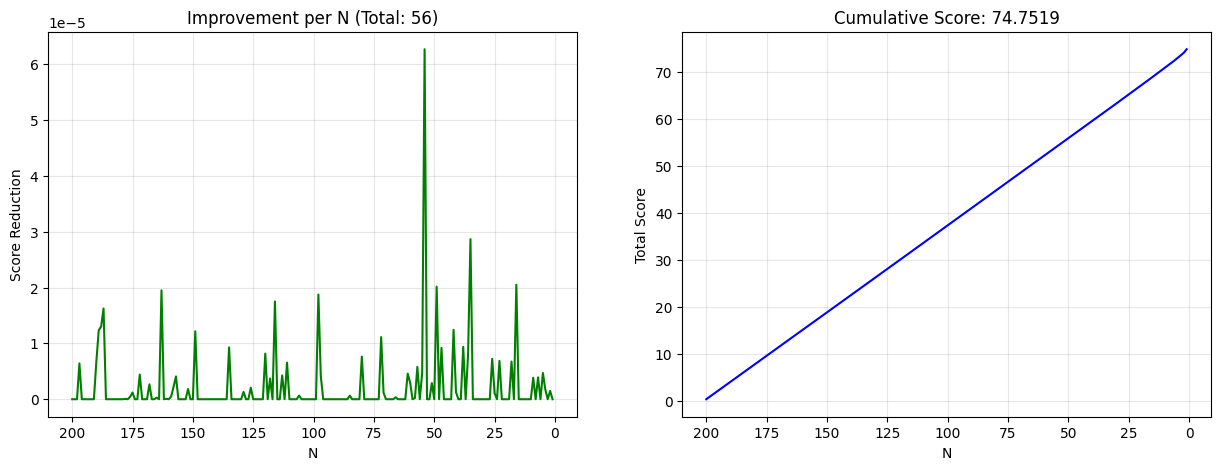

Processing Reverse:   0%|          | 0/200 [00:00<?, ?it/s]


--- Processing N=200 ---
  [N=200] Launching 8 parallel tasks (Removal & Optimization)...
  [N=200] Best candidate score: 0.371064
  [N=200] Baseline score: 0.371064
  [N=200] Score matched baseline (0.371064). No improvement.
  [N=200] Finished. Cumulative Score: 0.371064 | Total Improvements: 0
  [N=200] Best candidate score: 0.371064
  [N=200] Baseline score: 0.371064
  [N=200] Score matched baseline (0.371064). No improvement.
  [N=200] Finished. Cumulative Score: 0.371064 | Total Improvements: 0

--- Processing N=199 ---
  [N=199] Launching 8 parallel tasks (Removal & Optimization)...

--- Processing N=199 ---
  [N=199] Launching 8 parallel tasks (Removal & Optimization)...
  [N=199] Best candidate score: 0.372924
  [N=199] Baseline score: 0.369846
  [N=199] Baseline is better. Attempting to optimize baseline...
  [N=199] Best candidate score: 0.372924
  [N=199] Baseline score: 0.369846
  [N=199] Baseline is better. Attempting to optimize baseline...
  [N=199] Could not improve b

/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  [N=123] Best candidate score: 0.374350
  [N=123] Baseline score: 0.370113
  [N=123] Baseline is better. Attempting to optimize baseline...
  [N=123] Could not improve baseline.
  [N=123] Finished. Cumulative Score: 28.802719 | Total Improvements: 19

--- Processing N=122 ---
  [N=123] Could not improve baseline.
  [N=123] Finished. Cumulative Score: 28.802719 | Total Improvements: 19

--- Processing N=122 ---
  [N=122] Launching 96 parallel tasks (Removal & Optimization)...
  [N=122] Launching 96 parallel tasks (Removal & Optimization)...
  [N=122] Best candidate score: 0.373141
  [N=122] Baseline score: 0.370403
  [N=122] Baseline is better. Attempting to optimize baseline...
  [N=122] Best candidate score: 0.373141
  [N=122] Baseline score: 0.370403
  [N=122] Baseline is better. Attempting to optimize baseline...
  [N=122] Could not improve baseline.
  [N=122] Finished. Cumulative Score: 29.173122 | Total Improvements: 19

--- Processing N=121 ---
  [N=122] Could not improve baseli

In [20]:
from joblib import Parallel, delayed
import multiprocessing
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import os
import datetime

# Load baseline from test.csv
known_solutions = {}
try:
    print("Loading baseline from test.csv...")
    baseline_df = pd.read_csv('test.csv')
    
    def parse_s(val):
        return float(str(val).replace('s', ''))
    
    baseline_df['x'] = baseline_df['x'].apply(parse_s)
    baseline_df['y'] = baseline_df['y'].apply(parse_s)
    baseline_df['deg'] = baseline_df['deg'].apply(parse_s)
    
    for n in range(1, 201):
        prefix = f"{n:03d}_"
        rows = baseline_df[baseline_df['id'].str.startswith(prefix)]
        if len(rows) == n:
            trees = []
            for _, row in rows.iterrows():
                trees.append(ChristmasTree(row['x'], row['y'], row['deg']))
            known_solutions[n] = trees
            
    print(f"Loaded {len(known_solutions)} configurations from test.csv")
    
except Exception as e:
    print(f"Could not load baseline: {e}")

# Helper function for parallel execution (REVERSE MODE)
def process_beam_candidate_reverse(base_trees, n, packer_params, target_side=None, remove_idx=None, parent_id=None):
    """
    Takes a solution of size >= n.
    If size > n, removes trees to reach size n.
    Then optimizes.
    """
    # Re-seed random for this process to ensure unique behavior in optimization
    # Fix: Ensure seed is within 32-bit range for numpy
    seed_val = (int(time.time() * 1000000) + os.getpid() + (remove_idx if remove_idx is not None else 0)) % (2**32)
    random.seed(seed_val)
    np.random.seed(seed_val)
    
    current_trees = [ChristmasTree(t.center_x, t.center_y, t.angle) for t in base_trees]
    
    # Remove trees if needed (Shrink strategy)
    while len(current_trees) > n:
        if remove_idx is not None and remove_idx < len(current_trees):
            # Remove specific tree requested
            current_trees.pop(remove_idx)
            remove_idx = None # Only use once
        else:
            # Fallback: Remove a tree that contributes to the bounds
            # Cache the union computation
            union = unary_union([t.polygon for t in current_trees])
            minx, miny, maxx, maxy = union.bounds
            
            candidates_to_remove = []
            for i, t in enumerate(current_trees):
                tb = t.polygon.bounds
                if (abs(tb[0] - minx) < 1e-3 or abs(tb[1] - miny) < 1e-3 or 
                    abs(tb[2] - maxx) < 1e-3 or abs(tb[3] - maxy) < 1e-3):
                    candidates_to_remove.append(i)
            
            if candidates_to_remove:
                idx = random.choice(candidates_to_remove)
            else:
                idx = random.randint(0, len(current_trees) - 1)
            current_trees.pop(idx)
            
    # ADAPTIVE OPTIMIZATION based on N
    # Larger N needs more iterations, smaller N can converge faster
    # INCREASED ITERATIONS for better results (Numba allows much higher counts)
    iterations = max(200000, min(1000000, int(n * 5000)))  # Scale with N
    
    candidate_trees = optimize_packing(current_trees, {
        'iterations': iterations,
        'step_size': 1.0,         # Large steps to jump out of local minima
        'angle_step': 45.0,       # Large rotation freedom
        'initial_temp': 2.0,      # Very hot start
        'final_temp': 1e-5,       # Cool down thoroughly
        'compression': 0.1        # Strong gravity to close gaps
    }, target_side=target_side)
        
    # Score Candidate
    side_candidate = get_bounds(candidate_trees)
    score_candidate = (side_candidate ** 2) / n
    
    return (score_candidate, candidate_trees, parent_id)

# Helper for Forward Search (Hybrid)
def process_forward_candidate(n, packer_params):
    # Fix: Ensure seed is within 32-bit range for numpy
    seed_val = (int(time.time() * 1000000) + os.getpid()) % (2**32)
    random.seed(seed_val)
    np.random.seed(seed_val)
    
    packer = GreedyPacker(**packer_params)
    
    # Start with one tree
    trees = [ChristmasTree(0, 0, 0)]
    
    for _ in range(n - 1):
        next_tree = packer.place_next_tree(trees, ChristmasTree)
        trees.append(next_tree)
        
    # Optimize
    trees = optimize_packing(trees, {
        'iterations': 200000, # Increased from 10k
        'step_size': 0.5,
        'angle_step': 20.0,
        'initial_temp': 0.5,
        'compression': 0.05
    })
    
    side = get_bounds(trees)
    score = (side ** 2) / n
    return (score, trees, "forward")

# BEAM SEARCH PARAMETERS
BASE_BEAM_WIDTH = CONFIG['dynamic_beam_width']['base_width']
BRANCH_FACTOR = 8     # Generate 8 children per candidate
n_jobs = multiprocessing.cpu_count()
print(f"Running Advanced Search (200 -> 1) on {n_jobs} cores.")

packer_params = {'n_trials': 200, 'step_size': 0.2, 'fine_step': 0.01}
submission_rows = []
improvements = 0
all_solutions = {}

# Initialize candidates with the solution for N=200
# Structure: (trees, parent_id)
if 200 in known_solutions:
    print("Initializing with known solution for N=200.")
    current_candidates = [(known_solutions[200], "init")]
else:
    print("ERROR: No solution for N=200 found in baseline. Cannot start reverse search.")
    current_candidates = []

# Metrics Tracking
history_n = []
history_improvement = []
history_total_score = []
current_total_score = 0

# Setup Metrics File
os.makedirs('Data', exist_ok=True)
timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
metrics_file = f'Data/run_metrics_advanced_{timestamp_str}.csv'
with open(metrics_file, 'w') as f:
    f.write('n,score,baseline,improvement,source\n')

# Setup Realtime Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plt.close(fig) # Don't show yet
plot_display_id = "metrics_plot_advanced"
display(fig, display_id=plot_display_id) # Show initial empty plot

# REVERSE LOOP: 200 down to 1
for n in tqdm(range(200, 0, -1), desc="Processing Reverse"):
    
    print(f"\n--- Processing N={n} ---")

    # Dynamic Beam Width
    current_beam_width = BASE_BEAM_WIDTH
    if CONFIG['dynamic_beam_width']['enabled']:
        # Critical N values: 100, 50, 25, 10
        if n in [100, 50, 25, 10] or n <= 5:
            current_beam_width = int(BASE_BEAM_WIDTH * CONFIG['dynamic_beam_width']['critical_n_multiplier'])
            print(f"  [N={n}] Critical N! Widening beam to {current_beam_width}")

    # Get baseline side for pruning/comparison
    baseline_side = None
    if n in known_solutions:
        baseline_side = get_bounds(known_solutions[n])
    
    # 1. Expand candidates in parallel
    tasks = []
    # Enumerate candidates to assign parent IDs
    for p_idx, (base_trees, _) in enumerate(current_candidates):
        # Identify boundary trees for intelligent removal
        minx, miny, maxx, maxy = unary_union([t.polygon for t in base_trees]).bounds
        boundary_indices = []
        for i, t in enumerate(base_trees):
            tb = t.polygon.bounds
            # Check if touching global bounds
            if (abs(tb[0] - minx) < 1e-2 or abs(tb[1] - miny) < 1e-2 or 
                abs(tb[2] - maxx) < 1e-2 or abs(tb[3] - maxy) < 1e-2):
                boundary_indices.append(i)
        
        # If we have enough boundary trees, pick distinct ones. If not, fill with randoms.
        indices_to_try = boundary_indices[:BRANCH_FACTOR]
        while len(indices_to_try) < BRANCH_FACTOR:
            indices_to_try.append(None) # None triggers random selection inside function
            
        for idx in indices_to_try:
            # Pass p_idx as parent_id
            tasks.append((base_trees, n, packer_params, baseline_side, idx, p_idx))
            
    print(f"  [N={n}] Launching {len(tasks)} parallel tasks (Removal & Optimization)...")
    
    # Run in parallel
    results = []
    try:
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_beam_candidate_reverse)(t[0], t[1], t[2], t[3], t[4], t[5]) for t in tasks
        )
    except Exception as e:
        print(f"  [N={n}] ERROR in parallel execution: {e}")
        if n in known_solutions:
            results = [((get_bounds(known_solutions[n])**2)/n, known_solutions[n], "fallback")]
    
    # Hybrid Search: Inject Forward Candidates
    if CONFIG['hybrid_search']['enabled'] and n <= CONFIG['hybrid_search']['switch_n']:
        print(f"  [N={n}] Hybrid Search: Generating forward candidates...")
        # Generate a few forward candidates
        forward_tasks = [(n, packer_params) for _ in range(4)] # Try 4 forward starts
        try:
            forward_results = Parallel(n_jobs=n_jobs)(
                delayed(process_forward_candidate)(t[0], t[1]) for t in forward_tasks
            )
            results.extend(forward_results)
            print(f"  [N={n}] Added {len(forward_results)} forward candidates.")
        except Exception as e:
            print(f"  [N={n}] Forward search failed: {e}")

    # 2. Sort and select top K (Beam Selection with Diversity)
    results.sort(key=lambda x: x[0])
    if results:
        print(f"  [N={n}] Best candidate score: {results[0][0]:.6f}")
    else:
        print(f"  [N={n}] No results found!")
        continue
    
    # Update current candidates with diversity check
    unique_candidates = []
    seen_scores = set()
    parent_counts = {} # Track how many children from each parent
    
    max_children = CONFIG['beam_diversity']['max_children_per_parent'] if CONFIG['beam_diversity']['enabled'] else 999
    
    for res in results:
        score = round(res[0], 6)
        trees = res[1]
        pid = res[2]
        
        # Diversity Check 1: Score Uniqueness
        if score in seen_scores:
            continue
            
        # Diversity Check 2: Parent Limit
        p_count = parent_counts.get(pid, 0)
        if p_count >= max_children:
            continue
            
        unique_candidates.append((trees, pid))
        seen_scores.add(score)
        parent_counts[pid] = p_count + 1
        
        if len(unique_candidates) >= current_beam_width:
            break
            
    current_candidates = unique_candidates
    
    # The best candidate for this N
    best_score_greedy = results[0][0]
    best_trees_greedy = results[0][1]
    
    # 3. Compare with Baseline
    best_trees_n = best_trees_greedy
    best_score_n = best_score_greedy
    source = "ReverseGreedy"
    baseline_val = 0
    
    if n in known_solutions:
        known_trees = known_solutions[n]
        known_trees = center_packing(known_trees)
        side_known = get_bounds(known_trees)
        score_known = (side_known ** 2) / n
        baseline_val = score_known
        
        print(f"  [N={n}] Baseline score: {score_known:.6f}")

        # Compare (Lower is better)
        if score_known < best_score_greedy - 1e-7:
            best_trees_n = known_trees
            best_score_n = score_known
            source = "Baseline"
            print(f"  [N={n}] Baseline is better. Attempting to optimize baseline...")
            
            # Optimize Baseline (Aggressive pass)
            optimized_known = [ChristmasTree(t.center_x, t.center_y, t.angle) for t in known_trees]
            optimized_known = optimize_packing(optimized_known, {
                'iterations': 500000,      # 500k iterations
                'step_size': 0.8, 
                'angle_step': 20.0, 
                'initial_temp': 1.5,      # Hotter start
                'compression': 0.08
            })
            
            side_opt = get_bounds(optimized_known)
            score_opt = (side_opt ** 2) / n
            
            if score_opt < score_known - 1e-7:
                best_trees_n = optimized_known
                best_score_n = score_opt
                source = "Baseline+Opt"
                improvements += 1
                print(f"  [N={n}] !!! Baseline Optimized! {score_known:.6f} -> {score_opt:.6f}")
            else:
                print(f"  [N={n}] Could not improve baseline.")
                
            # Inject baseline into beam
            current_candidates.append((best_trees_n, "baseline"))
            # Re-sort beam
            temp_candidates = []
            for c, pid in current_candidates:
                s = get_bounds(c)
                temp_candidates.append(((s**2)/n, c, pid))
            temp_candidates.sort(key=lambda x: x[0])
            current_candidates = [(x[1], x[2]) for x in temp_candidates[:current_beam_width]]
            
        elif best_score_greedy < score_known - 1e-7:
            print(f"  [N={n}] !!! Reverse Search Found Improvement! {score_known:.6f} -> {best_score_greedy:.6f}")
            improvements += 1
        else:
            print(f"  [N={n}] Score matched baseline ({score_known:.6f}). No improvement.")
            
    # 4. Update State & Check Bounds
    all_solutions[n] = best_trees_n
    
    # Validation
    if CONFIG['validation']['strict_boundary']:
        for t in best_trees_n:
            if abs(t.center_x) > 100 or abs(t.center_y) > 100:
                print(f"WARNING: Tree at N={n} outside bounds: ({t.center_x:.2f}, {t.center_y:.2f})")
    
    if CONFIG['validation']['collision_check']:
        # Simple check
        polys = [t.polygon for t in best_trees_n]
        tree_index = STRtree(polys)
        for i, p in enumerate(polys):
            query = tree_index.query(p)
            for q in query:
                if q != i and p.intersects(polys[q]):
                     # Ignore touching
                     if not p.touches(polys[q]):
                         # Check intersection area
                         if p.intersection(polys[q]).area > 1e-6:
                             print(f"WARNING: Collision detected at N={n} between {i} and {q}")

    # 5. Metrics & Plotting
    current_total_score += best_score_n
    imp = max(0, baseline_val - best_score_n) if baseline_val > 0 else 0
    
    print(f"  [N={n}] Finished. Cumulative Score: {current_total_score:.6f} | Total Improvements: {improvements}")

    history_n.append(n)
    history_improvement.append(imp)
    history_total_score.append(current_total_score)
    
    # Save metrics
    with open(metrics_file, 'a') as f:
        f.write(f"{n},{best_score_n:.10f},{baseline_val:.10f},{imp:.10f},{source}\n")
        
    # Realtime Plot (Update every 5 steps)
    if n % 5 == 0 or n == 1:
        # Update axes
        ax1.clear()
        ax2.clear()
        
        # Note: history_n is decreasing [200, 199, ...]
        ax1.plot(history_n, history_improvement, 'g-', label='Improvement')
        ax1.set_title(f'Improvement per N (Total: {improvements})')
        ax1.set_xlabel('N')
        ax1.set_ylabel('Score Reduction')
        ax1.invert_xaxis() # Invert X axis to show 200 -> 1 flow
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(history_n, history_total_score, 'b-', label='Total Score')
        ax2.set_title(f'Cumulative Score: {current_total_score:.4f}')
        ax2.set_xlabel('N')
        ax2.set_ylabel('Total Score')
        ax2.invert_xaxis()
        ax2.grid(True, alpha=0.3)
        
        # Update the display
        display(fig, display_id=plot_display_id, update=True)
    
    # 6. Prepare Submission Rows
    for i, tree in enumerate(best_trees_n):
        submission_rows.append([
            f"{n:03d}_{i}", 
            f"s{tree.center_x:.10f}", 
            f"s{tree.center_y:.10f}", 
            f"s{tree.angle:.10f}"
        ])

print(f"Processing complete. Improvements over baseline/initial: {improvements}")

df_sub = pd.DataFrame(submission_rows, columns=['id', 'x', 'y', 'deg'])
# Sort by ID to ensure 001_... comes first
df_sub.sort_values('id', inplace=True)
df_sub.to_csv('submission.csv', index=False)
print("Submission generated.")


## 10. Evaluation Helper

Calculate the local score to estimate leaderboard performance.


In [21]:
## 9. Polishing & Refinement
# Run this cell to further optimize the existing submission using the new Numba engine.
# This is much faster than the full search and can squeeze out extra points.

print("Starting Polishing Phase...")
try:
    # Load current best submission
    if os.path.exists('submission.csv'):
        polish_df = pd.read_csv('submission.csv')
        print("Loaded submission.csv for polishing.")
    else:
        polish_df = pd.read_csv('test.csv')
        print("Loaded test.csv for polishing.")

    def parse_s(val):
        return float(str(val).replace('s', ''))
    
    polish_df['x'] = polish_df['x'].apply(parse_s)
    polish_df['y'] = polish_df['y'].apply(parse_s)
    polish_df['deg'] = polish_df['deg'].apply(parse_s)
    
    polish_solutions = {}
    for n in range(1, 201):
        prefix = f"{n:03d}_"
        rows = polish_df[polish_df['id'].str.startswith(prefix)]
        if len(rows) == n:
            trees = []
            for _, row in rows.iterrows():
                trees.append(ChristmasTree(row['x'], row['y'], row['deg']))
            polish_solutions[n] = trees

    total_score_before = 0
    total_score_after = 0
    
    # Polish each N
    for n in tqdm(range(1, 201), desc="Polishing"):
        if n not in polish_solutions: continue
        
        trees = polish_solutions[n]
        side_before = get_bounds(trees)
        score_before = (side_before ** 2) / n
        total_score_before += score_before
        
        # Run Numba Optimization
        # High iterations because it's fast!
        iters = 200000 if n < 50 else 500000
        
        optimized_trees = optimize_packing(trees, {
            'iterations': iters,
            'step_size': 0.5,
            'angle_step': 15.0,
            'initial_temp': 1.0,
            'final_temp': 1e-6
        })
        
        side_after = get_bounds(optimized_trees)
        score_after = (side_after ** 2) / n
        
        if score_after < score_before - 1e-9:
            polish_solutions[n] = optimized_trees
            total_score_after += score_after
            # print(f"  N={n} Improved: {score_before:.6f} -> {score_after:.6f}")
        else:
            total_score_after += score_before # Keep original
            
    print(f"Polishing Complete.")
    print(f"Score Before: {total_score_before:.6f}")
    print(f"Score After:  {total_score_after:.6f}")
    print(f"Improvement:  {total_score_before - total_score_after:.6f}")
    
    # Save if improved
    if total_score_after < total_score_before:
        new_rows = []
        for n in range(1, 201):
            if n in polish_solutions:
                for i, tree in enumerate(polish_solutions[n]):
                    new_rows.append([
                        f"{n:03d}_{i}", 
                        f"s{tree.center_x:.10f}", 
                        f"s{tree.center_y:.10f}", 
                        f"s{tree.angle:.10f}"
                    ])
        
        df_polished = pd.DataFrame(new_rows, columns=['id', 'x', 'y', 'deg'])
        df_polished.sort_values('id', inplace=True)
        df_polished.to_csv('submission_polished.csv', index=False)
        df_polished.to_csv('submission.csv', index=False) # Overwrite main
        print("Saved polished submission to submission.csv")
        
except Exception as e:
    print(f"Polishing failed: {e}")


Starting Polishing Phase...
Loaded submission.csv for polishing.


Polishing:   0%|          | 0/200 [00:00<?, ?it/s]

Polishing Complete.
Score Before: 74.751868
Score After:  74.751511
Improvement:  0.000357
Saved polished submission to submission.csv


In [ ]:
import os
import datetime

# Calculate final score
final_score = 0
for n, trees in all_solutions.items():
    side = get_bounds(trees)
    final_score += (side ** 2) / n

print(f"Final Score: {final_score:.10f}")

# Compare with original
if 'total_test_score' in globals():
    print(f"Original Score: {total_test_score:.10f}")
    if final_score < total_test_score:
        diff = total_test_score - final_score
        print(f"SUCCESS: Score improved by {diff:.10f}!")
        
        # 1. Save copy with detailed name
        os.makedirs('Data', exist_ok=True)
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        detailed_name = f"Data/submission_score{final_score:.2f}_improved{diff:.2f}_{timestamp}.csv"
        df_sub.to_csv(detailed_name, index=False)
        print(f"Saved backup: {detailed_name}")
        
        # 2. Overwrite test.csv
        df_sub.to_csv('test.csv', index=False)
        print("Overwrote test.csv")
        
        # 3. Submit to Kaggle
        message = f"Improved score {final_score:.6f} (was {total_test_score:.6f})"
        print("Submitting to Kaggle...")
        !kaggle competitions submit -c santa-2025 -f submission.csv -m "{message}"

        # 4. Git Commit and Push
        print("Committing and pushing to Git...")
        !git add .
        !git commit -m "{message}"
        !git push
        
    else:
        print(f"No improvement (Current: {final_score:.10f} >= Original: {total_test_score:.10f}).")
else:
    print("Original score not found. Run the first cell to load test.csv baseline.")